##  Giới thiệu

Trong bài này, chúng ta sử dụng PyTorch và xây dựng một mạng CNN đơn giản. Sau đó chúng ta sẽ huấn luyện và đánh giá model với tập dữ liệu MNIST nhé.

## Lưu ý về cách làm bài tập
Các bạn điền vào phần **None** và các đoạn code đã được ẩn đi.


### Tổng quan một mạng CNN cơ bản

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

### MNIST dataset

Trong bài tập này, chúng ta sẽ sử dựng tập MNIST rất nổi tiếng vể  các chữ số viết tay từ 0->9. Tập dataset này bao gồm 60000 ảnh cho training và 10000 ảnh cho testing. Các bức ảnh này đều đã được căn giữa và chỉnh với kích thước cố định là 28x28.

Trong phần tiền xử lý, chúng ta sẽ cần chuẩn hóa các giá trị pixel của mỗi ảnh về khoảng [0,1], kiểu dữ liệu sẽ là float32

<!-- ![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png) -->

Chi tiết tại: http://yann.lecun.com/exdb/mnist/

## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

from torchsummary import summary

## Setup

- Chúng ta sẽ setup một số hyper-parameters cũng như một số giá trị cần dùng theo hướng dẫn nhé
- Ở đây, các bạn vào Runtime, chọn Change the runtime type và chọn GPU nhé.

### Parameters

In [ ]:
# Số classes trong tập MNIST
num_classes = 10 

# Số epoch
epochs = 1

# Các tham số cần thiết trong quá trình training
learning_rate = 0.001
batch_size = 128
display_step = 100

# Model path
checkpoint = 'model.pth'

# device: cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Download MNIST dataset in local system

In [ ]:
# Định nghĩa tham số transform
transform=transforms.Compose([
    transforms.ToTensor(), # Chuyển ảnh sang dạng Tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize ảnh với mean và standard deviation là 0.5
    ])

# Load MNIST dataset từ torchvision.datasets
train_data = datasets.MNIST(
    root='data', 
    train=True, 
    transform=transform, 
    download=True
)
test_data = datasets.MNIST(
    root='data', 
    train=False, 
    transform=transform,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


**Visualization of MNIST dataset**

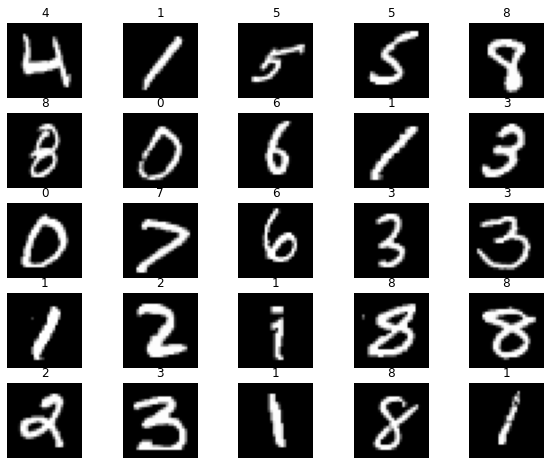

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Preparing data for training with DataLoaders
- Để tiện cho việc xử lý dữ dữ liệu vào các batches cũng như reshuffle dữ liệu qua mỗi epoch thì chúng ta sẽ sử dụng hàm sẵn có của PyTorch là [DataLoader](https://pytorch.org/docs/stable/data.html) 

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Model

- Trong bài này, chúng ta sẽ định nghĩa một class Net để xây dựng một model có cấu trúc như hình ở đầu notebook. Tuy nhiên, ở đây để tăng khả năng học của mô hình thì các hãy thêm vào layer `ReLU` và layer `Dropout`. Mô hình sẽ có cấu trúc như sau: `3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear`
- Kích thước ảnh đầu vào: (1, 28, 28)
- Ở đây, các layer `Conv2d` có các thông số lần lượt là: `filter = 32, 64, 64; kernel_size = 3; stride = 1; valid padding`
- Các layer `Linear` lần lượt số node là `128, 64, num_classes`
- Sau layer `MaxPool2d` thì `height` và `width` của ảnh sẽ giảm đi một nửa
- Hệ số layer `Dropout` = 0.3
- Tham khảo: [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=11*11*64, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        ### START CODE HEAR ≈ 18 lines
        ## 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        ### END CODE HERE
        return x

In [ ]:
# Load model vào GPU
model = Net().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          36,928
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
           Dropout-8           [-1, 64, 11, 11]               0
           Flatten-9                 [-1, 7744]               0
           Linear-10                  [-1, 128]         991,360
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
             ReLU-13                   [-1, 64]               0
           Linear-14                   

## Training phase



In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam Optimizer set params=model.parameters(), lr=learning_rate
best_val_loss = 999

# Loop for each epoch
for epoch in range(1, epochs + 1):

    # Quá trình training 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Clear gradients for this training step 
        optimizer.zero_grad()
        output = model(data)

        # Backpropagation, compute gradients
        loss = criterion(output, target)
        loss.backward()

        # Apply gradients
        optimizer.step()
        if batch_idx % display_step == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # Quá trình testing 
    model.eval()
    test_loss = 0
    correct = 0
    # Set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = F.log_softmax(output, dim=1) # Sử dụng hàm log_sotmax để tính xác suất cho output
            test_loss += criterion(output, target) 
            pred = output.argmax(dim = 1, keepdim = True) # Sử dụng hàm argmax để lấy predicted label, chú ý: dim = 1, keepdim=True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset) 
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint)  # Lưu model path
      print("***********    TEST_ACC = {:.2f}%    ***********".format(correct/100))

Train Epoch 1: [0/60000 (0%)]	Train Loss: 2.300171
Train Epoch 1: [12800/60000 (21%)]	Train Loss: 0.113698
Train Epoch 1: [25600/60000 (43%)]	Train Loss: 0.102324
Train Epoch 1: [38400/60000 (64%)]	Train Loss: 0.096079
Train Epoch 1: [51200/60000 (85%)]	Train Loss: 0.117683
***********    TEST_ACC = 98.23%    ***********


In [ ]:
# Load lại model đã train
model.load_state_dict(torch.load(checkpoint))

# Xem lại thông số của model 
model.eval()

Net(
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Prediction

In [ ]:
# Lấy ra một batch trong tập test
item = iter(test_loader)
data, target = item.next()

# Lấy random index của một phần tử trong batch đó
test_idx = random.choice(range(len(data)))

# Lấy một ví dụ trong tập test
data = data[test_idx]
target = target[test_idx]
assert data.shape == (1, 28, 28)

In [ ]:
# Predict sử dụng model đã train
def plot(data, model):
  data = torch.unsqueeze(data, dim=0) # unsqueeze data
  data = data.to(device)
  output = model(data)
  output = F.log_softmax(output, dim=1) # log softmax, chú ý dim
  pred = output.argmax(dim=1, keepdim=True) # argmax, chú ý keepdim, dim=1
  print("Predict Number : ", pred[0][0].detach().cpu().numpy()) 
  plt.imshow(data[0][0].detach().cpu().numpy(), cmap='gray')
  plt.show()

Predict Number :  8


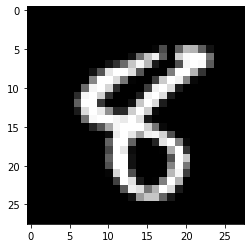

In [ ]:
plot(data, model)

## More Exercises

### Exercise 1: VGG-like model
* Implement a simplified VGG model by building 3 'blocks' of 2 convolutional layers each
* Do MaxPooling after each block
* The first block should use at least 32 filters, later blocks should use more
* You can use 3x3 filters
* Use zero-padding to be able to build a deeper model (see the `padding` attribute)
* Use a dense layer with at least 128 hidden nodes.
* You can use ReLU activations everywhere (where it makes sense)
* Plot and interpret the learning curves

### Exercise 2: Regularization
* Explore different ways to regularize your VGG-like model
  * Try adding some dropout after every MaxPooling and Dense layer.
    * What are good Dropout rates? Try a fixed Dropout rate, or increase the rates in the deeper layers.
  * Try batch normalization together with Dropout
    * Think about where batch normalization would make sense 
* Plot and interpret the learning curves
